In [129]:
def get_id(line):
    return "_".join(map(str, [line['chromosome_name'], line['start']]))

import pandas as pd
table = pd.read_table("A1.tsv")
table['id']=table.apply(get_id, axis=1)
table = table.set_index('id')
table.columns

ref_cols = ['tumor.rcnt.llr3_ref','adrenalmet.rcnt.llr3_ref', 'livermet.rcnt.llr3_ref', 'lungmet.rcnt.llr3_ref', 'spinalmet.rcnt.llr3_ref']
var_cols = ['tumor.rcnt.llr3_var','adrenalmet.rcnt.llr3_var', 'livermet.rcnt.llr3_var', 'lungmet.rcnt.llr3_var', 'spinalmet.rcnt.llr3_var']

#breast,adrenal,liver,lung,spinal
cols = ['breast', 'adrenal', 'liver', 'lung', 'spinal']
table = table[['cluster']+ref_cols+var_cols]
table.columns = ['cluster']+['ref-'+c for c in cols] + ['var-'+c for c in cols]
table.head()

table.head()

,cluster,ref-breast,ref-adrenal,ref-liver,ref-lung,ref-spinal,var-breast,var-adrenal,var-liver,var-lung,var-spinal
id,,,,,,,,,,,
1_110359957,7,150,158,104,151,142,4,2,20,0,0
6_48902663,6,189,150,97,147,178,0,27,0,1,0
6_49276467,9,117,91,144,85,63,1,0,0,0,17
6_50173697,9,179,117,92,126,115,0,0,0,0,30
6_50179508,6,141,113,98,113,128,0,26,0,0,0


In [130]:
filename="../../../../result/hoadley_2016/treeomics/A1_sub/mutations.txt"

clusters = []
tree = {}
with open(filename) as f:
    for i,line in enumerate(f):
        line = line.strip().split(" ")
        if line[1] not in tree:
            tree[line[1][:-1]] = (line[0][:-1], i+1)
        else:
            tree[line[1][:-1]+"_2"] = (line[0][:-1], i+1)
        clusters.append(line[2:])

        
table['tcluster'] = 0
for i, cluster in enumerate(clusters):
    for idx in cluster:
        v = "_".join(idx.split('__')[:2])
        try:
            table.loc[v]["tcluster"] = i+1
        except:
            print idx
        

In [131]:
for sample in tree:
    curs = sample
    if sample.startswith('SC'): continue
    print sample
    while True:
        try:
            print tree[curs][1]
            curs = tree[curs][0]
        except:
            break

spinal
6
2
1
liver_SC1
12
7
1
lung
5
3
2
1
breast
4
3
2
1
adrenal
9
8
7
1
breast_SC1
11
7
1
liver
10
8
7
1


In [132]:
def get_vaf(row, sam):
    return float(row['var-'+sam])/float(row['var-'+sam]+row['ref-'+sam])

#ctable_cutoff = table.groupby('cluster').mean()
vafs = pd.DataFrame()
for sam in cols:
    vafs[sam] = table.apply(get_vaf, args=[sam], axis=1)
vafs['cluster'] = table['cluster']
vafs['tcluster'] = table['tcluster']

In [133]:
vafs.groupby(['tcluster', 'cluster']).mean()

breast   adrenal     liver      lung    spinal
tcluster cluster                                                  
1        1        0.283901  0.330158  0.438077  0.191010  0.200579
2        3        0.228888  0.000710  0.000846  0.149339  0.194938
3        5        0.225846  0.001270  0.001753  0.142480  0.004489
         8        0.191176  0.000000  0.000000  0.047170  0.000000
4        8        0.203798  0.000407  0.000430  0.003941  0.000000
6        9        0.000902  0.000894  0.000275  0.001013  0.190299
7        2        0.062006  0.400941  0.445730  0.015618  0.002354
         4        0.049134  0.254255  0.271277  0.003668  0.000841
8        2        0.027259  0.434409  0.427594  0.019017  0.000000
         4        0.020496  0.207729  0.221792  0.003663  0.000719
9        6        0.000549  0.223056  0.001972  0.001001  0.000542
10       7        0.026130  0.000621  0.217263  0.000651  0.000000

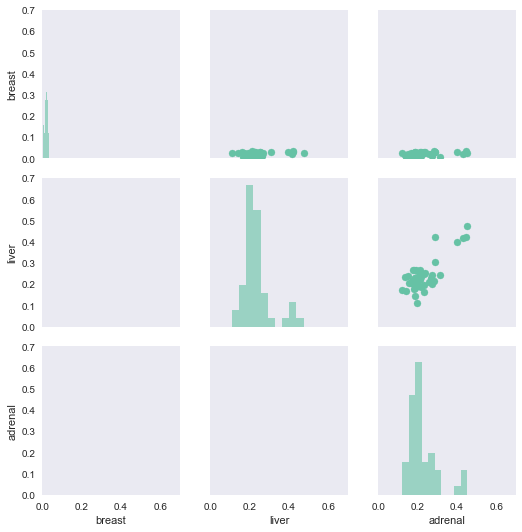

In [143]:
%matplotlib inline
from matplotlib import pyplot
v_sub = vafs[(vafs['tcluster'] == 8) | (vafs['tcluster'] == 8)]
import seaborn as sns
g = sns.PairGrid(v_sub, hue = 'tcluster', vars = ['breast', 'liver', 'adrenal'])
g = g.map_upper(pyplot.scatter)
g = g.map_diag(pyplot.hist, alpha = 0.6)
g = g.set(xlim=(0,0.7), ylim=(0,0.7))

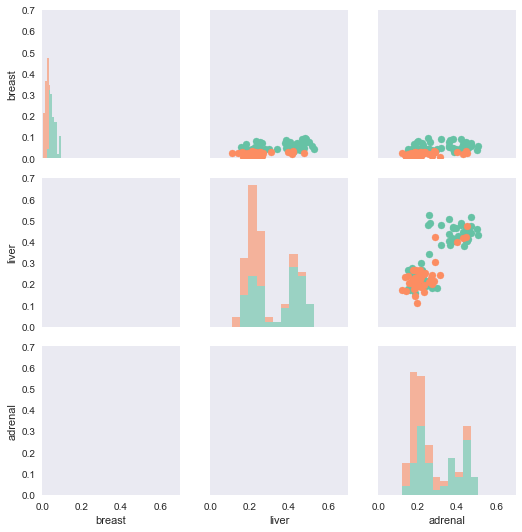

In [139]:
from matplotlib import pyplot
v_sub = vafs[(vafs['tcluster'] == 7 ) | (vafs['tcluster'] == 8)]
import seaborn as sns
g = sns.PairGrid(v_sub, hue = 'tcluster', vars = ['breast', 'liver', 'adrenal'])
g = g.map_upper(pyplot.scatter)
g = g.map_diag(pyplot.hist, alpha = 0.6)
g = g.set(xlim=(0,0.7), ylim=(0,0.7))

(48, 7)
48


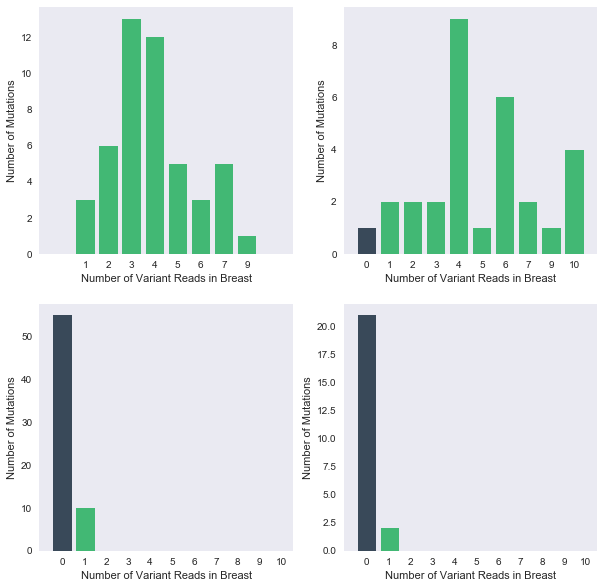

In [136]:
print vafs[vafs['tcluster']==8].shape
print sum(table[table['tcluster']==8]['var-breast'] > 0)
pyplot.subplot(2,2,1)
sns.countplot(table[table['tcluster']==8]['var-breast'], palette = sns.color_palette(["#2ecc71"]))
pyplot.xlabel("Number of Variant Reads in Breast")
pyplot.ylabel("Number of Mutations")
pyplot.xlim((-2, 9))
pyplot.subplot(2,2,2)
sns.countplot(table[table['tcluster']==10]['var-breast'], palette = sns.color_palette(["#34495e"]+["#2ecc71"]*10))
pyplot.xlabel("Number of Variant Reads in Breast")
pyplot.ylabel("Number of Mutations")
pyplot.xlim((-1, 10))
#pyplot.xticks([0.90*v for v in range(0,11)], range(0,11))
pyplot.subplot(2,2,3)
sns.countplot(table[table['tcluster']==6]['var-breast'], palette = sns.color_palette(["#34495e"]+["#2ecc71"]*10))
pyplot.xlabel("Number of Variant Reads in Breast")
pyplot.ylabel("Number of Mutations")
pyplot.xlim((-1, 10))
pyplot.xticks([0.95*v for v in range(0,11)], range(0,11))
pyplot.subplot(2,2,4)
sns.countplot(table[table['tcluster']==9]['var-breast'], palette = sns.color_palette(["#34495e"]+["#2ecc71"]*10))
pyplot.xlabel("Number of Variant Reads in Breast")
pyplot.ylabel("Number of Mutations")
pyplot.xlim((-1, 10))
pyplot.xticks([0.95*v for v in range(0,11)], range(0,11))
pyplot.gcf().set_size_inches(10,10)
#pyplot.savefig

#"#34495e", 


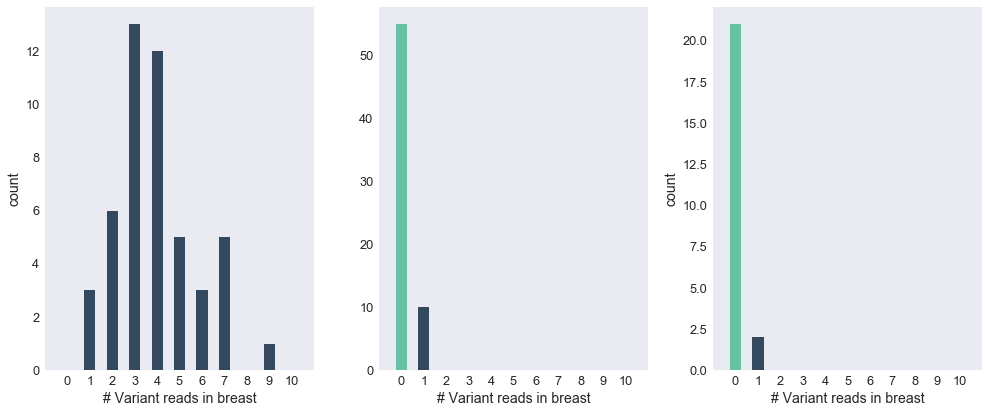

In [228]:
sns.set_style('dark')

#sns.palplot(sns.color_palette("Set2", 10))
for j,cluster in enumerate([8,6,9]):
    pyplot.subplot(1,3,j+1)
    v = table[table['tcluster']==cluster]['var-breast'].value_counts()
    for i in range(0,11):
        if  i not in v: v[i]=0
    v.sort_index(inplace=True)
    sns.set_palette(sns.color_palette(["#34495e"]+["#2ecc71"]*10))
    v.plot(kind='bar', rot=0)

    sns.set_palette(sns.color_palette("Set2", 10))
    v[[0]].plot(kind='bar', rot=0)
    pyplot.xlim((-1,11))
    pyplot.xticks(range(0,11), range(0,11))
    #if i in [0,1]: pyplot.ylim(0,20)
    #else:  pyplot.ylim(0,60)

    pyplot.xlabel('# Variant reads in breast')
    if j in [0,2]: pyplot.ylabel('count')
pyplot.gcf().set_size_inches(14,6)
pyplot.savefig('Read_Distribution.pdf')
pyplot.tight_layout()

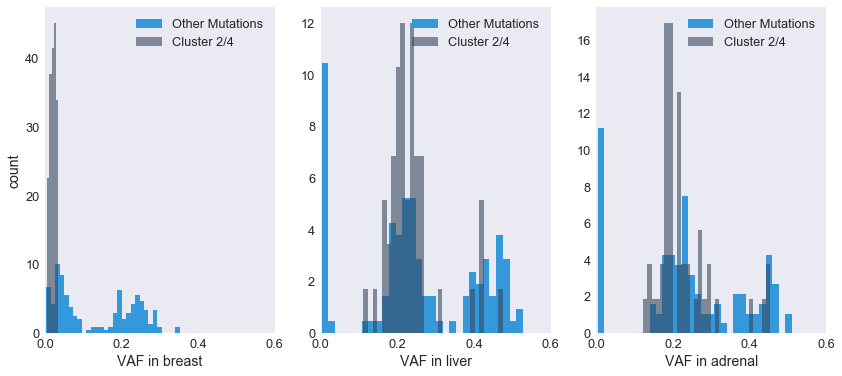

In [230]:
sns.set_context("paper", font_scale=1.6)
sns.set_palette(sns.color_palette(["#3498db", "#34495e"]))
colors = ['dusty pink']
sns.xkcd_palette(colors)
vafs['c8'] = (vafs['tcluster'] == 8) 
for i,site in enumerate(['breast', 'liver', 'adrenal']): 
    pyplot.subplot(1,3,i+1)
    #v_sub = vafs[(vafs['tcluster'] == 8)]
    vsub = vafs[vafs[site]!= 0]
    
    # pyplot.xlim((0,0.6))
    
    #sns.distplot(vsub[vsub['c8'] == False][site], kde=False,  hist=True, bins=30, label='Other Mutations')
    #sns.distplot(vsub[vsub['c8'] == True][site], kde=False, hist=True, label='Cluster 2/4)
    pyplot.hist(vsub[vsub['c8'] == False][site],bins=30, label='Other Mutations' ,normed=True )
    if site == 'breast':
        bins = 5
    else: bins = 30
        
    pyplot.hist(vsub[vsub['c8'] == True][site], bins = bins, label='Cluster 2/4', alpha = 0.6, normed=True)
    
    pyplot.xlim(0,0.6)
    #sns.stripplot(vafs[site])
    pyplot.legend()
    #sns.stripplot(v_sub[site])
    #sns.swarmplot(data = vafs, y = site, x = 'c8' )
    #sns.violinplot(data = vafs, y = 'breast', hue = 'c8', split = 'True')
    pyplot.xlabel('VAF in '+site)
    if i == 0: pyplot.ylabel('count')

pyplot.gcf().set_size_inches(14,6)
pyplot.savefig('Hist_cluster2.pdf')

In [177]:
print len((vafs['tcluster'] == 8) )

329


In [ ]:
ax = sns.violinplot(x="day", y="total_bill", hue="smoker", data=tips, palette="muted", split=True)

In [178]:
print len(vafs[site])

329


In [179]:
(vafs['tcluster'] == 8) 

id
1_110359957    False
6_48902663     False
6_49276467     False
6_50173697     False
6_50179508     False
6_50519104     False
6_50534952     False
6_50568504     False
6_50909762     False
6_51288265     False
6_53035144      True
6_55918529     False
6_57180847     False
6_58602457     False
6_96859305     False
6_97417052     False
6_97473303     False
6_97912586     False
6_98144517      True
6_99123934     False
6_99144022     False
6_100130338    False
6_101334520    False
6_102992907    False
6_103034674    False
6_103399899     True
6_103477515    False
6_103604780    False
6_103810336    False
6_104027186    False
               ...  
19_35635072    False
19_36351696    False
19_36621094    False
19_36821124     True
19_39059284    False
19_40094764    False
19_42129322    False
19_42312834    False
19_44578501    False
19_44652253    False
19_44778597    False
19_44991316     True
19_46786035    False
19_57034973    False
19_57610720    False
19_57897877    False
19_5832602